# Demo for the DoWhy causal API
We show a simple example of adding a causal extension to any dataframe. 

In [1]:
import dowhy.datasets
import dowhy.api

import numpy as np
import pandas as pd

from statsmodels.api import OLS

In [2]:
data = dowhy.datasets.linear_dataset(beta=5,
        num_common_causes=1,
        num_instruments = 0,
        num_samples=1000,
        treatment_is_binary=True)
df = data['df']
df['y'] = df['y'] + np.random.normal(size=len(df)) # Adding noise to data. Without noise, the variance in Y|X, Z is zero, and mcmc fails.
#data['dot_graph'] = 'digraph { v ->y;X0-> v;X0-> y;}'

treatment= data["treatment_name"][0]
outcome = data["outcome_name"][0]
common_cause = data["common_causes_names"][0]
df

,W0,v0,y
0,-0.867364,False,0.119670
1,1.155602,True,6.253767
2,-0.280300,True,4.200077
3,-1.048648,False,-0.598016
4,-0.738004,True,4.272890
...,...,...,...
995,-1.904239,False,-0.219956
996,-1.014407,False,0.237404
997,-0.623400,False,0.589520
998,-1.758007,True,4.772884


<Axes: xlabel='v0'>

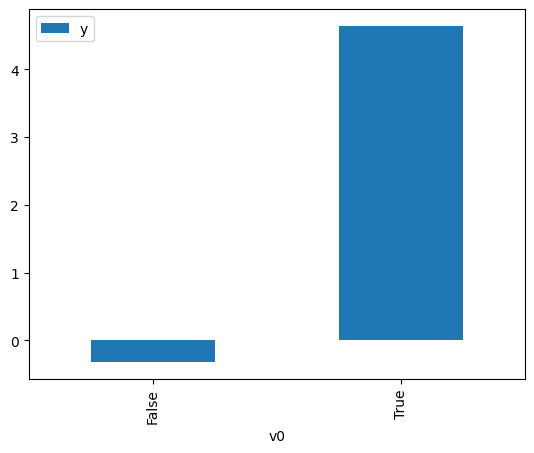

In [3]:
# data['df'] is just a regular pandas.DataFrame
df.causal.do(x=treatment,
                     variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'},
                     outcome=outcome,
                     common_causes=[common_cause],
                     proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

<Axes: xlabel='v0'>

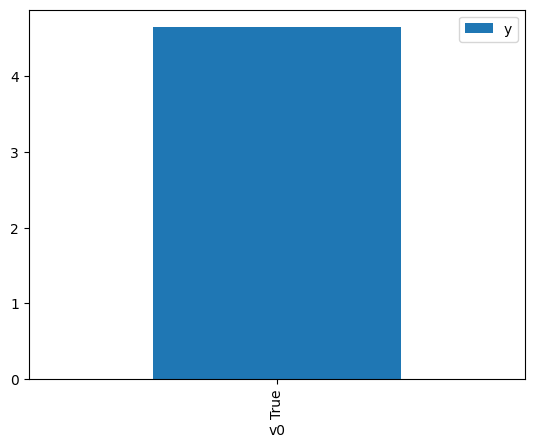

In [4]:
df.causal.do(x={treatment: 1}, 
              variable_types={treatment:'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome,
              method='weighting', 
              common_causes=[common_cause],
              proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

In [5]:
cdf_1 = df.causal.do(x={treatment: 1}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)

cdf_0 = df.causal.do(x={treatment: 0}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)


In [6]:
cdf_0

,W0,v0,y,propensity_score,weight
0,-2.087894,False,-1.868729,0.851013,1.175070
1,0.021262,False,1.157249,0.473802,2.110587
2,-0.368156,False,0.239259,0.558780,1.789614
3,-1.104333,False,-0.385573,0.707039,1.414350
4,0.327702,False,1.449487,0.407742,2.452530
...,...,...,...,...,...
995,-1.026826,False,1.507699,0.692781,1.443457
996,-0.569513,False,0.386693,0.601707,1.661937
997,-1.310278,False,-1.269742,0.742965,1.345959
998,-0.238773,False,-0.626005,0.530682,1.884369


In [7]:
cdf_1

,W0,v0,y,propensity_score,weight
0,-1.981416,True,4.365866,0.161203,6.203342
1,1.103236,True,4.219903,0.741277,1.349024
2,0.536958,True,3.535795,0.635665,1.573155
3,-2.275672,True,5.415775,0.129313,7.733176
4,-1.006280,True,3.625694,0.311062,3.214790
...,...,...,...,...,...
995,-2.285609,True,4.312222,0.128336,7.792036
996,-1.685022,True,5.451126,0.199458,5.013580
997,-0.894567,True,6.676045,0.332410,3.008335
998,-0.360538,True,3.790063,0.442866,2.258018


## Comparing the estimate to Linear Regression
First, estimating the effect using the causal data frame, and the 95% confidence interval.

In [8]:
(cdf_1['y'] - cdf_0['y']).mean()

In [9]:
1.96*(cdf_1['y'] - cdf_0['y']).std() / np.sqrt(len(df))

Comparing to the estimate from OLS.

In [10]:
model = OLS(np.asarray(df[outcome]), np.asarray(df[[common_cause, treatment]], dtype=np.float64))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.894
Model:                            OLS   Adj. R-squared (uncentered):              0.893
Method:                 Least Squares   F-statistic:                              4189.
Date:                Wed, 15 Nov 2023   Prob (F-statistic):                        0.00
Time:                        15:41:48   Log-Likelihood:                         -1394.3
No. Observations:                1000   AIC:                                      2793.
Df Residuals:                     998   BIC:                                      2802.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.2743      0.022     12.523      0.000       0.231       0.317
x2             4.9160      0.054     91.453      0.000       4.810       5.021
==============================================================================
Omnibus:                        0.674   Durbin-Watson:                   1.986
Prob(Omnibus):                  0.714   Jarque-Bera (JB):                0.745
Skew:                          -0.056   Prob(JB):                        0.689
Kurtosis:                       2.927   Cond. No.                         2.51
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""